# Basic tests with SimplePatternLearner module

In [1]:
import os
import torch
import matplotlib.pyplot as plt

from dataset.utils import load_pickle_data, save_dict
from ML.utils import correlation
from ML.architecture import SimplePatternLearner, CorrelationLoss
from ripdalib.variations.transform import list_to_matrix, matrix_to_list
from ripdalib.variations.plot import plot_matrix, plot_correlation, plot_patterns_from_correlation

## Initiation

In [2]:
IMAGE = load_pickle_data(os.path.join("Fugues_data", "data_16.pkl"))["BWV_0846"]
MAX_EPOCH = 200
LEARNING_RATE = 0.1
EPSILON = 0.0000001
PATTERN_MAXSIZE = (4*16, 10)

MINDIV = 16 #from Fugues_data.midi_to_pkl import MINDIV

torch.manual_seed(689)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
matrix_image = list_to_matrix(IMAGE, MINDIV)

In [4]:
module = SimplePatternLearner(PATTERN_MAXSIZE)
loss = CorrelationLoss().square_regul(beta=5, smooth_function=3, mean_size=10)

## Training

In [13]:
torch.manual_seed(689)
#module.reset()
module.learn_pattern(matrix_image, loss, learning_rates=LEARNING_RATE, maxepoch=MAX_EPOCH, epsilon=EPSILON)

Training...:   4%|██▎                                               | 9/200 [00:02<00:45,  4.18it/s]

Current_loss = -0.26925620436668396


Training...:  10%|████▋                                            | 19/200 [00:04<00:42,  4.29it/s]

Current_loss = -0.27237558364868164


Training...:  14%|███████                                          | 29/200 [00:06<00:39,  4.30it/s]

Current_loss = -0.5205148458480835


Training...:  20%|█████████▌                                       | 39/200 [00:09<00:37,  4.30it/s]

Current_loss = -0.7231218814849854


Training...:  24%|████████████                                     | 49/200 [00:11<00:35,  4.26it/s]

Current_loss = -0.9147890210151672


Training...:  30%|██████████████▍                                  | 59/200 [00:14<00:34,  4.05it/s]

Current_loss = -2.823932647705078


Training...:  34%|████████████████▉                                | 69/200 [00:16<00:29,  4.37it/s]

Current_loss = -7.35194206237793


Training...:  40%|███████████████████▎                             | 79/200 [00:18<00:29,  4.15it/s]

Current_loss = -17.812265396118164


Training...:  44%|█████████████████████▊                           | 89/200 [00:21<00:25,  4.29it/s]

Current_loss = -18.983652114868164


Training...:  50%|████████████████████████▎                        | 99/200 [00:23<00:23,  4.28it/s]

Current_loss = -18.98518943786621


Training...:  55%|██████████████████████████▏                     | 109/200 [00:26<00:21,  4.19it/s]

Current_loss = -18.985376358032227


Training...:  56%|███████████████████████████                     | 113/200 [00:26<00:20,  4.19it/s]

Epsilon was reached in 113 fits.
Last loss : -18.98542213


In [14]:
SAVE = True
FILE = "temp.pkl"

if SAVE:
    save_dict(module.state_dict(), FILE)
else:
    module.load_state_dict(load_pickle_data(FILE))

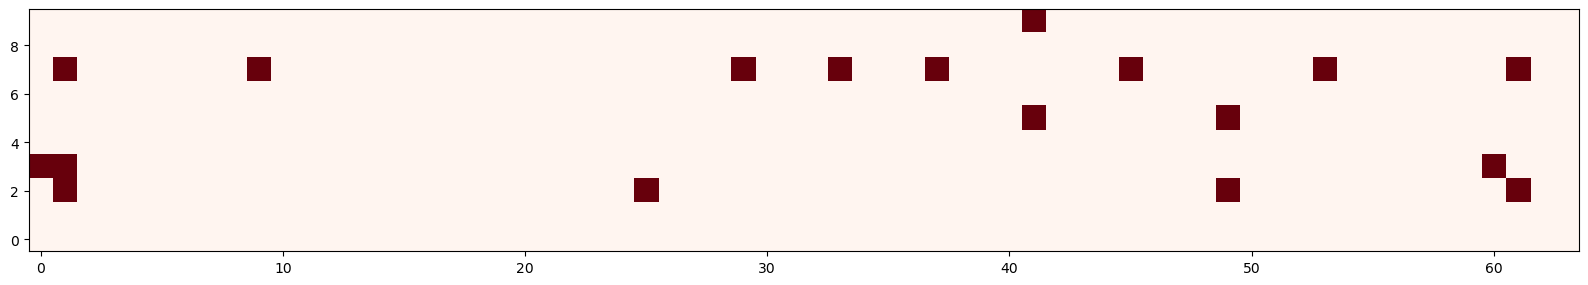

tensor(1.)


In [15]:
plot_correlation(module.pattern.squeeze((0,1)))
with torch.no_grad():
    print(torch.max(module.pattern))

In [16]:
print(torch.sum(module.pattern))
print(matrix_to_list(module.pattern.squeeze((0,1)) > 0.5, mindiv=MINDIV))

tensor(17.9995)
[(Fraction(0, 1), 3), (Fraction(1, 16), 2), (Fraction(1, 16), 3), (Fraction(1, 16), 7), (Fraction(9, 16), 7), (Fraction(25, 16), 2), (Fraction(29, 16), 7), (Fraction(33, 16), 7), (Fraction(37, 16), 7), (Fraction(41, 16), 5), (Fraction(41, 16), 9), (Fraction(45, 16), 7), (Fraction(49, 16), 2), (Fraction(49, 16), 5), (Fraction(53, 16), 7), (Fraction(15, 4), 3), (Fraction(61, 16), 2), (Fraction(61, 16), 7)]


In [17]:
test = module.pattern.squeeze((0,1))
((test.sum() - 10)**2).sum()

tensor(63.9913)

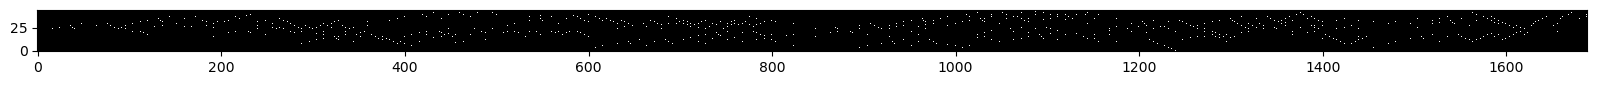

In [18]:
plot_matrix(matrix_image)

dilatation on erosion of the pattern give 0 element.


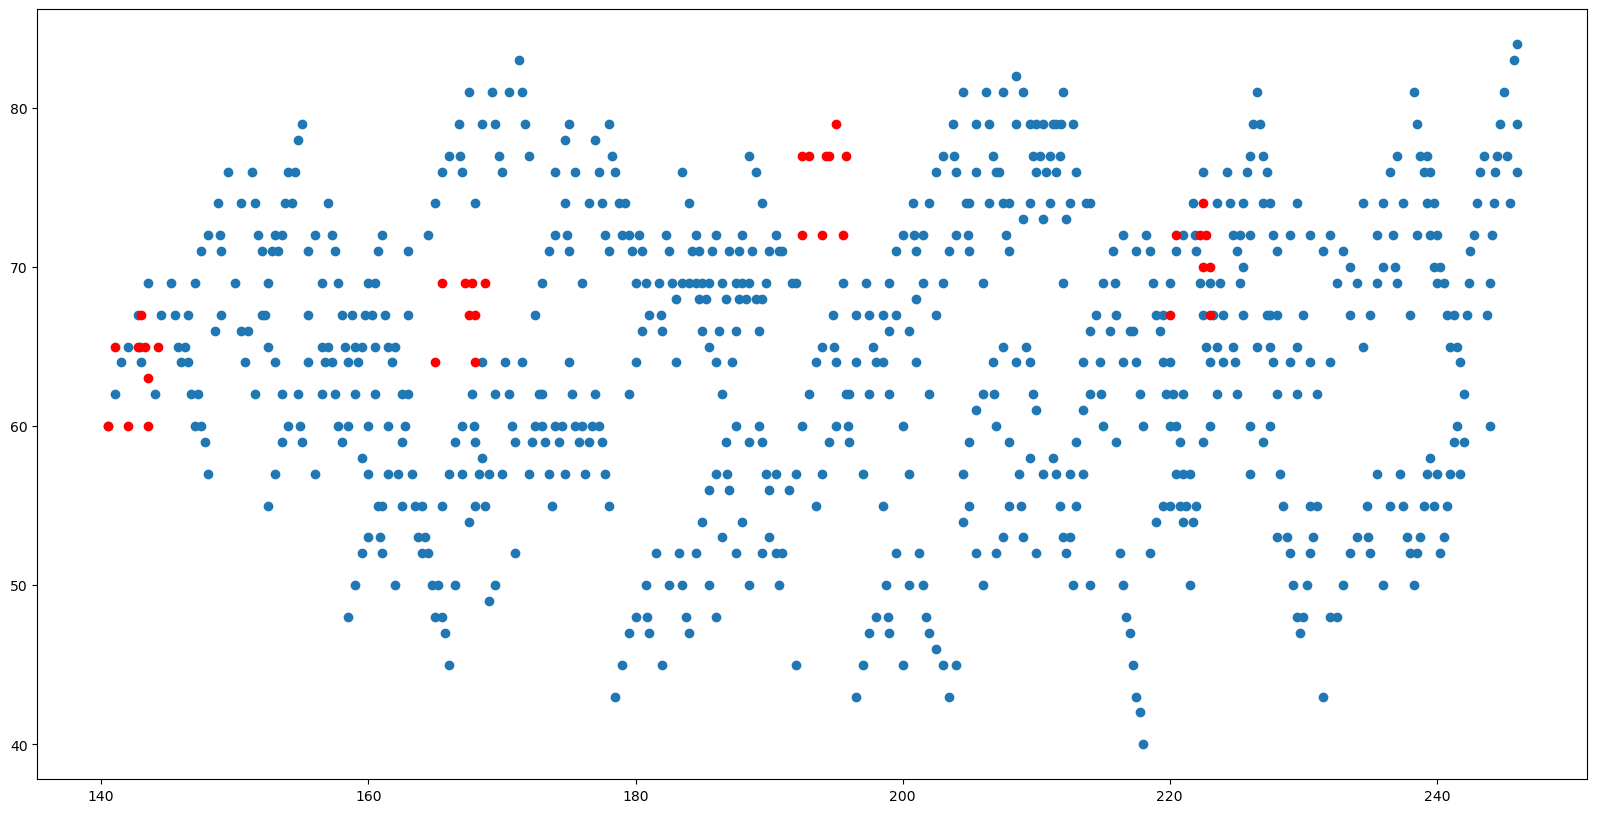

In [19]:
plot_patterns_from_correlation(module.correlation(matrix_image), IMAGE, module.pattern.squeeze((0,1)) >0.5, threshold=0.4, quantization=MINDIV)

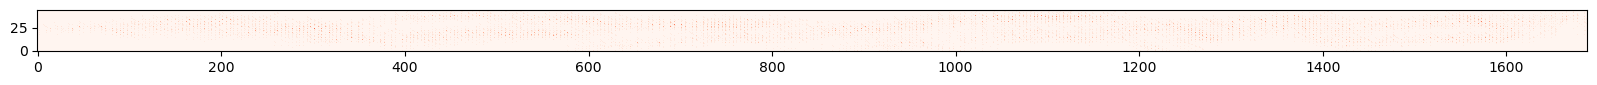

tensor(0.5000)


In [20]:
plot_correlation(module.correlation(matrix_image).squeeze((0,1)))
with torch.no_grad():
    print(torch.max(module.correlation(matrix_image)))

## Loss behavior

- The interaction between beta and the smooth function is really sensitive.
- The basic kernel learns extreme value
- Positive beta give noise map
- High Negative beta give the one element, from 0 to -high we get a decrease number of points in the pattern, but often it does not have exact apparition even once in the original piece
- Beta does not seem to be correlated with the input neither the pattern size, but deeper investigation should be done. An adaptative beta during training could give results.
- Generally the training find a suddent "local minimum hole" and have a quick deacreasing before stopping. In a bigger training with mini-batch training, we may find a better minimum
- for the loss, the best model is still to just "be on tatum time at nearly the same pitch" if we tune it a bit

Drawbacks :
- see this as an optiization problem is of course not optimal and create probable high instability
- Training on one example which must contain noise due to basic midi quantization (even if the files are mostly clean) must not be optimal.

Residuals : supprimer le pattern dominant et recommencer

Division d'un pattern en 2 avec les channels ?
Difference trop stricte ? #Future work, voir avec 1 seul déjà
Future path : PCA...